In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#IMPORTS
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [3]:
location = 'nw2'
turbine = 'c02'
mode = 'SS2'

In [4]:
# GET THE DATA
package_folder = os.path.dirname(os.path.dirname(os.getcwd()))
data_folder = os.path.join(package_folder, 'data')
selected_data_little = pd.read_csv(os.path.join(data_folder, 'processed','nw2', turbine+'_ss2_selected_data_little.csv'))
selected_data_large = pd.read_csv(os.path.join(data_folder, 'processed','nw2', turbine+'_ss2_selected_data_large.csv'))

In [5]:
from src.data.utils import get_input_data
from src.data.harmonics import *

data = get_input_data(data_folder, location, turbine)
harmonics_data = harmonics(data['turbine_data'].filter(regex='rpm'), [1,3,6, 9])

In [6]:
selected_columns = [
        'mean_NW2_C02_rpm',
        'mean_NW2_C02_pitch', 
        'mean_NW2_C02_power',
        'mean_NW2_C02_windspeed',
        'sin_mean_NW2_C02_yaw', 'cos_mean_NW2_C02_yaw',
        'sin_mean_NW2_C02_winddirection', 'cos_mean_NW2_C02_winddirection',
        'mvbc_WandelaarBuoy_Wave_height',
        #'mvbc_WandelaarBuoy_Average_wave_period',
        'mvbc_WandelaarMeasuringpile_Tide_TAW',
        #'mvbc_WandelaarMeasuringpile_Air_pressure',
        #'mvbc_WandelaarMeasuringpile_Air_temperature'
       ]

dropped mvbc columns:  {'mvbc_WandelaarBuoy_Sea_water_temperature', 'mvbc_WandelaarMeasuringpile_Relative_humidity'}


C:\Users\Max\AppData\Local\Temp\ipykernel_21100\4109450010.py:76: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend1.legendHandles:
C:\Users\Max\AppData\Local\Temp\ipykernel_21100\4109450010.py:103: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in combined_legend.legendHandles:


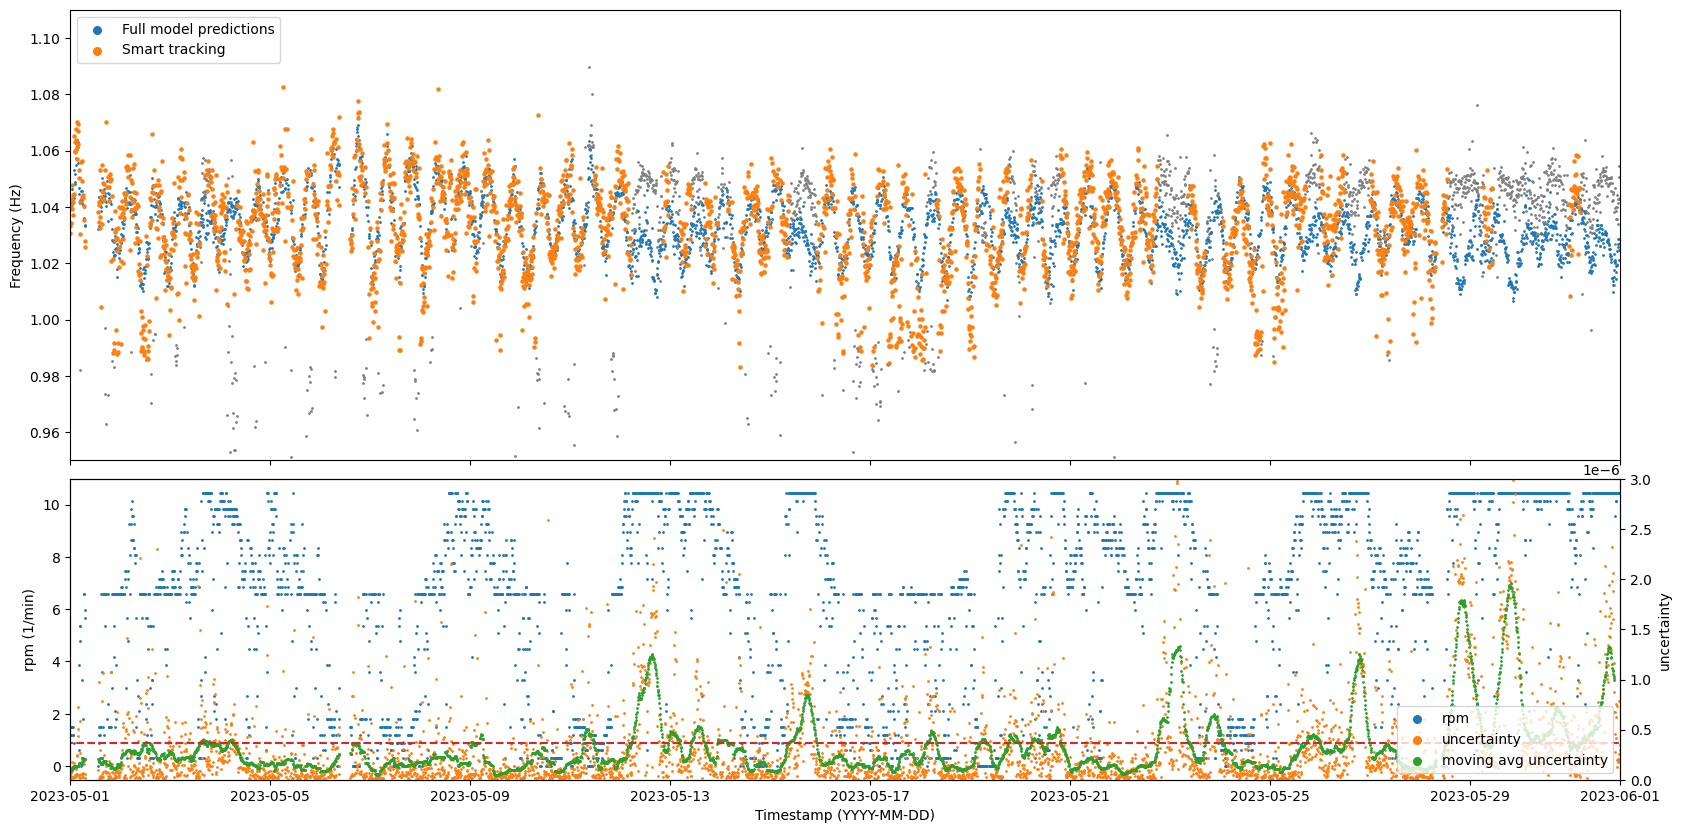

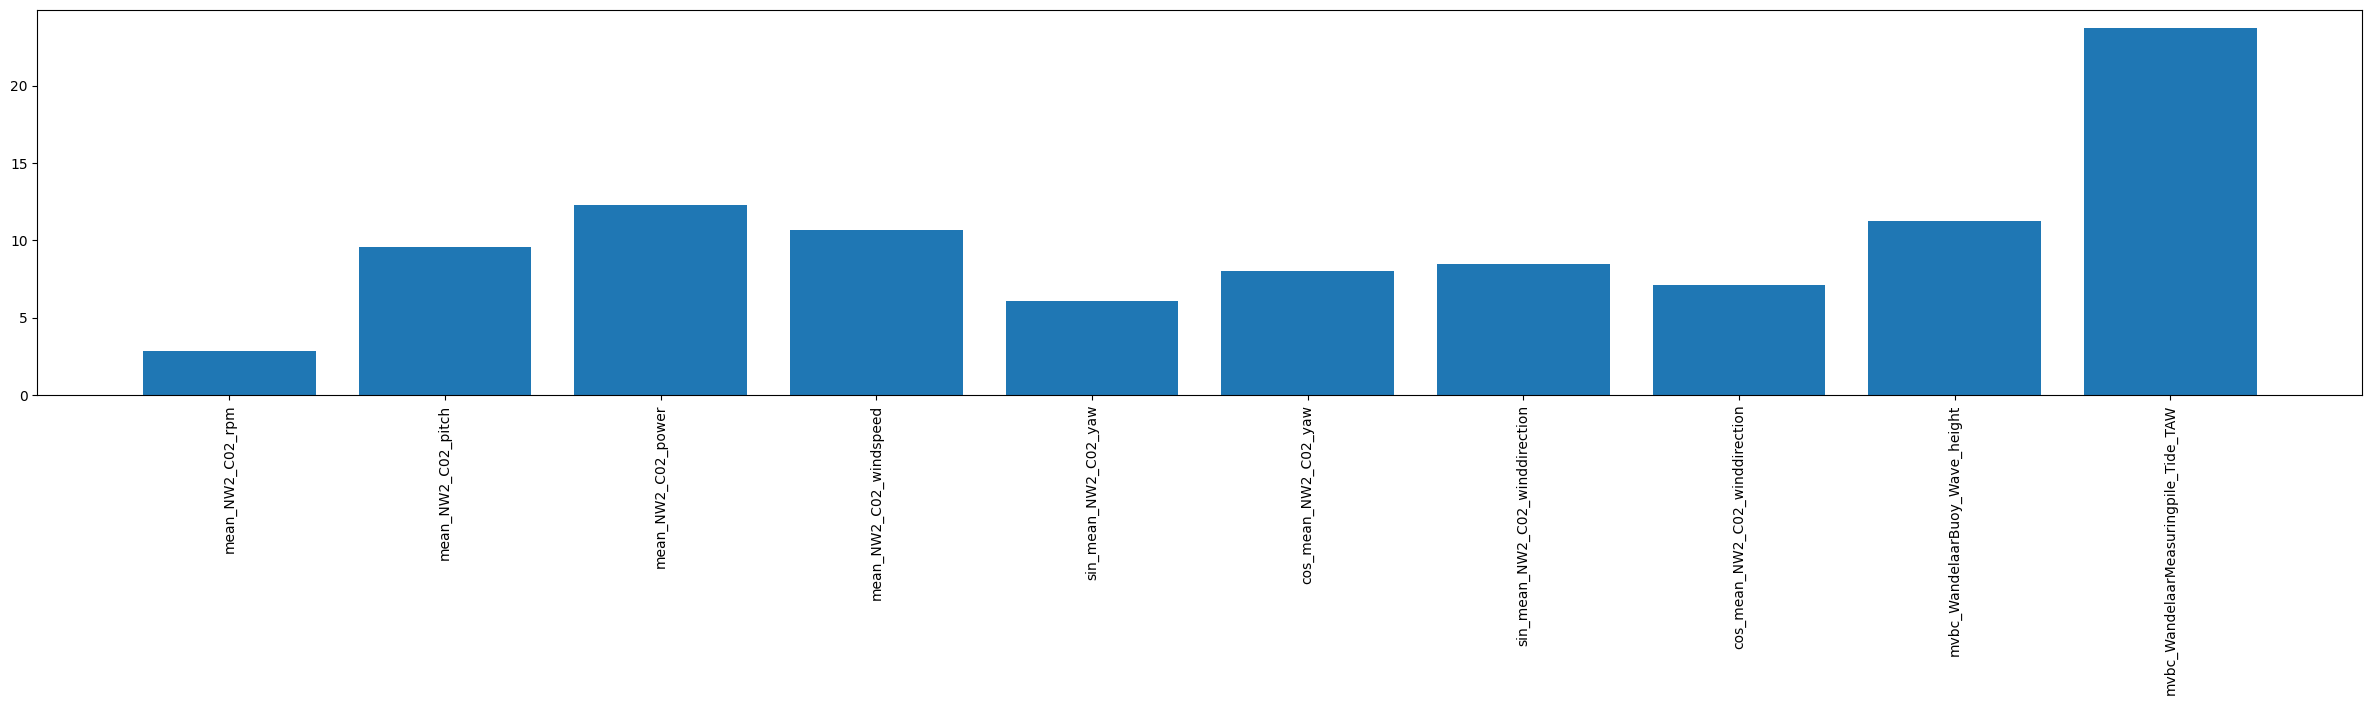

In [7]:
from src.data.make_dataset import create_input_target_dataset
from src.smart_tracking.smart_tracking import smart_tracking
X, y = create_input_target_dataset(data_folder, location, turbine, mode)

# Remove the selecyted data with duplicated timestamps and keep the one with the biggest size
selected_data_sorted = selected_data_large.sort_values(by='size', ascending=False)
selected_data_unique = selected_data_sorted.drop_duplicates(subset='timestamp', keep='first')
selected_data_unique = selected_data_unique.sort_values(by='timestamp')

y_train = selected_data_unique[['mean_frequency']].set_index(selected_data_unique['timestamp'])
y_train.index = pd.to_datetime(y_train.index)
y_train = y_train.loc[y_train.index.intersection(X.index)]
X_train = X.loc[y_train.index]
X_train = X_train[selected_columns]

from catboost import CatBoostRegressor
regr_model = CatBoostRegressor(iterations=1000, depth=3, learning_rate=0.5, random_seed=13,posterior_sampling=True, loss_function='RMSEWithUncertainty', verbose=False)
regr_model.fit(X_train, y_train)

import pickle
models_folder = os.path.join(package_folder, 'models', location)
model_path = os.path.join(models_folder, 'catboost_model_large.pkl')
with open(model_path, 'wb') as file:
    pickle.dump(regr_model, file)

# Full model predictions
predictions = regr_model.predict(X)
predictions_df = pd.DataFrame(predictions, columns=['prediction', 'spread'], index=X.index)
predicted_value = predictions[:,0]
predicted_total_uncertainty = predictions[:,1]

# Virtual ensemble predictions
virtual_ensemble_preds = regr_model.virtual_ensembles_predict(X, prediction_type='TotalUncertainty', virtual_ensembles_count=500, ntree_end=1000) #, virtual_ensembles_count=100, ntree_end=200)
virtual_ensemble_preds_df = pd.DataFrame(virtual_ensemble_preds, columns=['prediction', 'knowledge uncertainty', 'data uncertainty'], index=X.index)

virtual_ensemble_preds_mean = virtual_ensemble_preds[:,0] # mean values predicted by a virtual ensemble
knowledge_uncertainty = virtual_ensemble_preds[:,1] # knowledge uncertainty predicted by a virtual ensemble
data_uncertainty = virtual_ensemble_preds[:,2] # average estimated data uncertainty

import matplotlib.pyplot as plt
import datetime

uncertainty_ = pd.Series(knowledge_uncertainty, index=X.index).copy()
uncertainty_moving_avg = pd.Series(uncertainty_, index=X.index).rolling(6*6, center=True).mean()
uncertainty_lim = uncertainty_moving_avg.loc[X_train.index].quantile(0.99)

prediction_lim = (y - predictions_df['prediction']).loc[X_train.index].quantile(0.99)
prediction_lim = (y - predictions_df['prediction']).loc[X_train.index].std()*3


smart_tracked_modes = smart_tracking(y, predictions_df['prediction'], uncertainty_moving_avg, uncertainty_lim, prediction_lim)
#smart_tracked_modes.to_csv(os.path.join(data_folder, 'processed', location, turbine+'_'+mode+'_smart_tracked_modes_large_training.csv'))
smart_tracked_modes.to_parquet(os.path.join(data_folder, 'processed', location, turbine+'_'+mode+'_smart_tracked_modes_large_training.parquet'))

model_path = os.path.join(models_folder, '_'.join([location, turbine, mode, 'catboost_model_large.pkl']))

predictions_df['virtual_ensemble_mean'] = virtual_ensemble_preds_mean
predictions_df['knowledge_uncertainty'] = knowledge_uncertainty
predictions_df['data_uncertainty'] = data_uncertainty
predictions_df['residual'] = y - predictions_df['prediction']

#predictions_df.to_csv(os.path.join(data_folder, 'processed', location, turbine+'_'+mode+'_mode_prediction_large_training.csv'))
predictions_df.to_parquet(os.path.join(data_folder, 'processed', location, turbine+'_'+mode+'_mode_prediction_large_training.parquet'))

y_low_uncertainty = y.loc[uncertainty_moving_avg < uncertainty_lim]
# Create two subplots with shared x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10), sharex=True, gridspec_kw={'height_ratios': [3, 2]})

# Plot on the first subplot
ax1.scatter(y.index, y, s=1, color='grey')
ax1.scatter(predictions_df.index, predictions_df['prediction'], s=1, color='tab:blue', label='Full model predictions')
ax1.scatter(smart_tracked_modes.index, smart_tracked_modes['frequency'], s=5, color='tab:orange', label='Smart tracking')
ax1.set_ylim(0.95, 1.11)
legend1 = ax1.legend(loc='upper left')

for handle in legend1.legendHandles:
    handle.set_sizes([30])
ax1.set_ylabel('Frequency (Hz)')

# Plot on the second subplot
ax2.scatter(X.index, X.filter(regex='rpm'), label='rpm', s=1, color='tab:blue')
ax2.set_ylabel('rpm (1/min)')
ax2.set_xlabel('Timestamp (YYYY-MM-DD)')

ax3 = ax2.twinx()
ax3.scatter(uncertainty_.index,uncertainty_, label='uncertainty', s=1, color='tab:orange')
ax3.scatter(uncertainty_moving_avg.index,uncertainty_moving_avg, label='moving avg uncertainty', s=1, color='tab:green')

ax3.hlines(uncertainty_lim, uncertainty_.index[0], uncertainty_.index[-1], color='tab:red', linestyles='dashed')
ax3.set_ylabel('uncertainty')
ax3.set_ylim(0, 3*1e-6)

# Collect handles and labels for ax2 and ax3
handles2, labels2 = ax2.get_legend_handles_labels()
handles3, labels3 = ax3.get_legend_handles_labels()

# Combine handles and labels
combined_handles = handles2 + handles3
combined_labels = labels2 + labels3

# Create a single combined legend
combined_legend = plt.legend(combined_handles, combined_labels, loc='lower right')
for handle in combined_legend.legendHandles:
    handle.set_sizes([30])

# Set shared x-axis properties
plt.xlim(datetime.datetime(2023, 5, 1), datetime.datetime(2023, 6, 1))
plt.subplots_adjust(hspace=0.05)  # Adjust this value as needed

plt.show()
plt.close()

plt.figure(figsize=(30,5))
plt.bar(regr_model.feature_names_, regr_model.feature_importances_)
plt.xticks(rotation=90)
plt.show()
plt.close()


C:\Users\Max\AppData\Local\Temp\ipykernel_21100\421375868.py:36: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handles in legend.legendHandles:


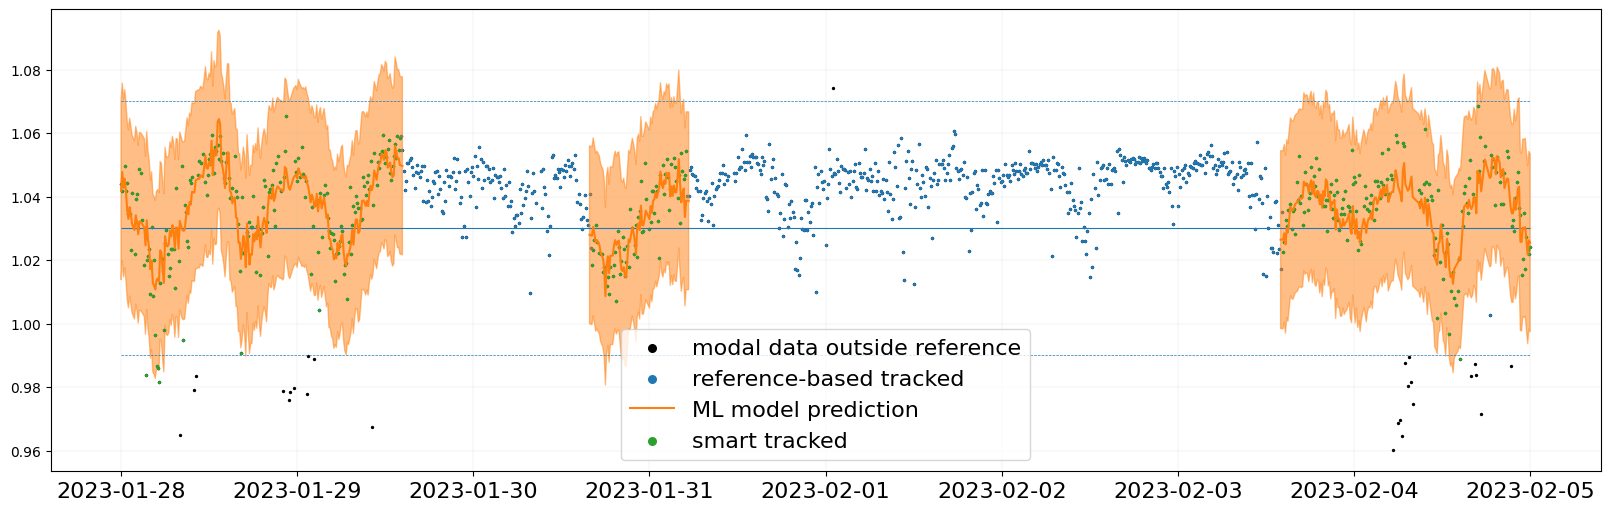

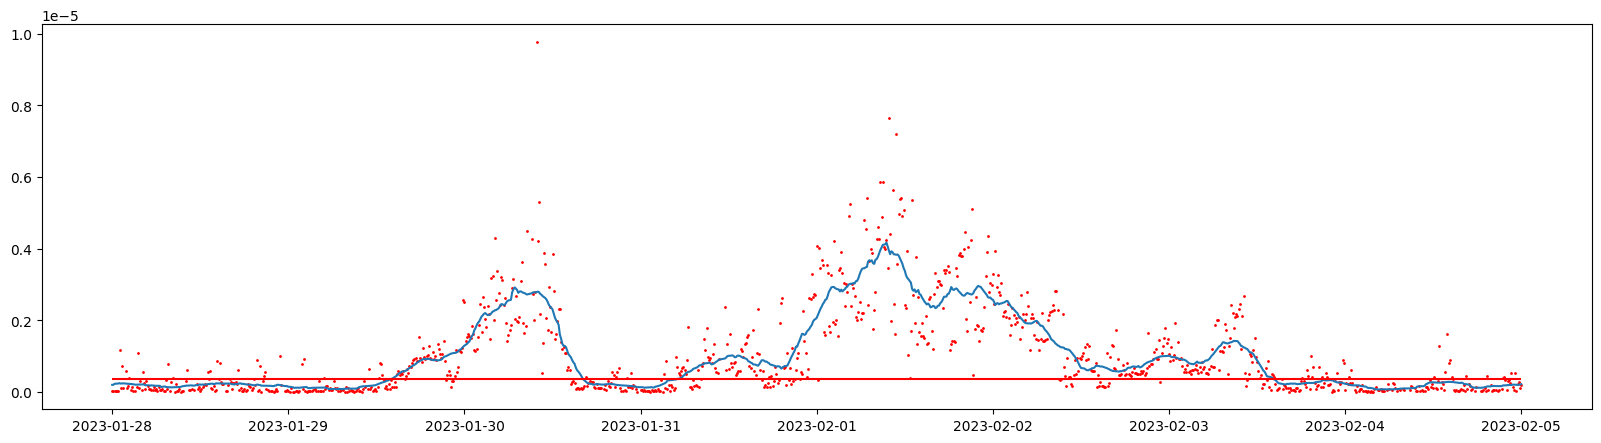

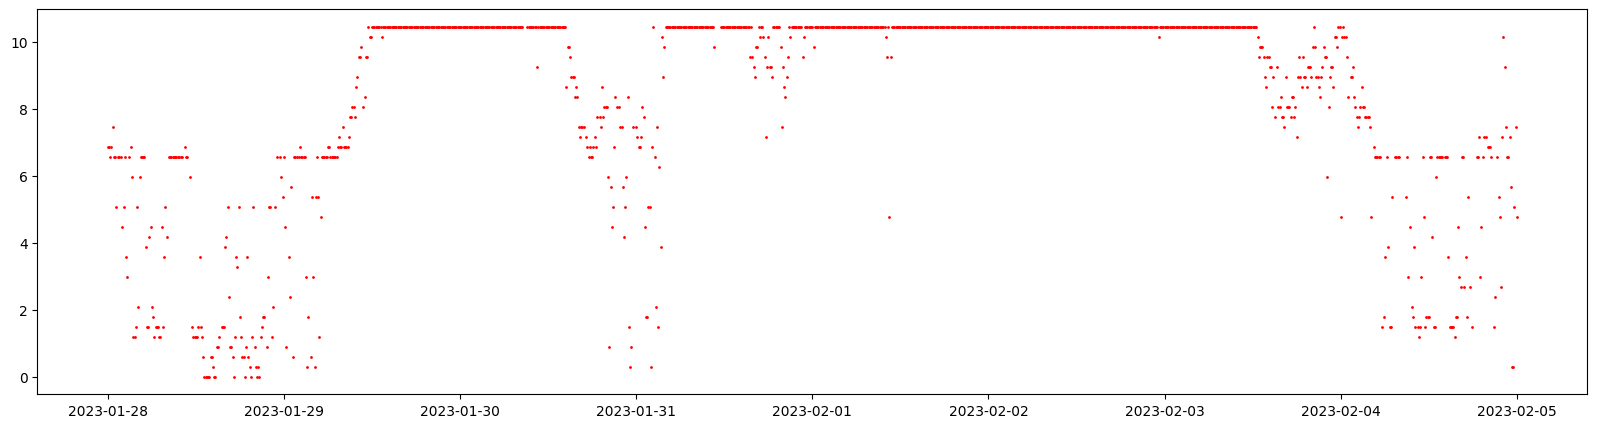

In [8]:
analyzed_timeframe = (
    datetime.datetime(2023, 1, 28, tzinfo=datetime.timezone.utc),
    datetime.datetime(2023, 2, 5, tzinfo=datetime.timezone.utc)
)
#prediction_lim = np.abs((y - predictions_df['prediction']).loc[X_train.index]).quantile(0.99)
prediction_lim = (y - predictions_df['prediction']).loc[X_train.index].std()*2

plt_selected_input_data = X.loc[analyzed_timeframe[0]:analyzed_timeframe[1]]
plt_modal_data = y.loc[analyzed_timeframe[0]:analyzed_timeframe[1]]
plt_predictions = predictions_df.loc[analyzed_timeframe[0]:analyzed_timeframe[1]]
low_uncertainty = uncertainty_[uncertainty_moving_avg < uncertainty_lim].index
common_indices = plt_predictions.index.intersection(low_uncertainty)
plt_predictions_low_uncertainty = plt_predictions.loc[common_indices]
resampled_plt_predictions = plt_predictions_low_uncertainty.resample('10T').asfreq()['prediction']
resampled_plt_predictions.interpolate(method='linear', inplace=True, limit_direction='both', limit=2)
plt_smart_tracked = smart_tracked_modes.loc[analyzed_timeframe[0]:analyzed_timeframe[1]]

upper_ref = 1.07
lower_ref = 0.99
reference_tracked = plt_modal_data[(plt_modal_data > lower_ref) & (plt_modal_data < upper_ref)]

plt.figure(figsize=(20, 6))
plt.scatter(plt_modal_data.index, plt_modal_data, color='k', s=2, label='modal data outside reference')
plt.hlines(upper_ref, analyzed_timeframe[0], analyzed_timeframe[1], color='tab:blue', linewidth=0.5, linestyle='--')
plt.hlines(lower_ref, analyzed_timeframe[0], analyzed_timeframe[1], color='tab:blue', linewidth=0.5, linestyle='--')
plt.hlines((lower_ref+upper_ref)/2 , analyzed_timeframe[0], analyzed_timeframe[1], color='tab:blue', linewidth=0.8)
plt.scatter(reference_tracked.index, reference_tracked, color='tab:blue', s=2, label='reference-based tracked')
#plt.plot(plt_predictions['prediction'])
#plt.scatter(plt_predictions.index, plt_predictions['prediction'], color='tab:orange', s=1)
#plt.scatter(plt_predictions_low_uncertainty.index, plt_predictions_low_uncertainty['prediction'], color='tab:blue', s=10)
plt.plot(resampled_plt_predictions, color='tab:orange', label='ML model prediction')
plt.fill_between(resampled_plt_predictions.index, resampled_plt_predictions-prediction_lim, resampled_plt_predictions+prediction_lim, alpha=0.5, color='tab:orange')

plt.scatter(plt_smart_tracked.index, plt_smart_tracked['frequency'], color='tab:green', s=2, label='smart tracked')
legend = plt.legend(loc='lower center', fontsize=16)
for handles in legend.legendHandles:
    try:
        handles.set_sizes([30.0])
    except:
        pass
plt.xticks(fontsize=16)
plt.grid(linewidth=0.1)
plt.show()
plt.close()

plt.figure(figsize=(20,5))
plt.plot(uncertainty_moving_avg.loc[analyzed_timeframe[0]:analyzed_timeframe[1]])
plt.hlines(uncertainty_lim, analyzed_timeframe[0], analyzed_timeframe[1], color='r')
plt.scatter(virtual_ensemble_preds_df.loc[analyzed_timeframe[0]:analyzed_timeframe[1]].index, virtual_ensemble_preds_df.loc[analyzed_timeframe[0]:analyzed_timeframe[1]]['knowledge uncertainty'], s=1, c='r')
plt.show()
plt.close()
plt.figure(figsize=(20,5))
plt.scatter(plt_selected_input_data.index, plt_selected_input_data['mean_NW2_C02_rpm'], s=1, c='r')
plt.show()
plt.close()

C:\Users\Max\AppData\Local\Temp\ipykernel_21100\3773566246.py:37: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handles in legend.legendHandles:


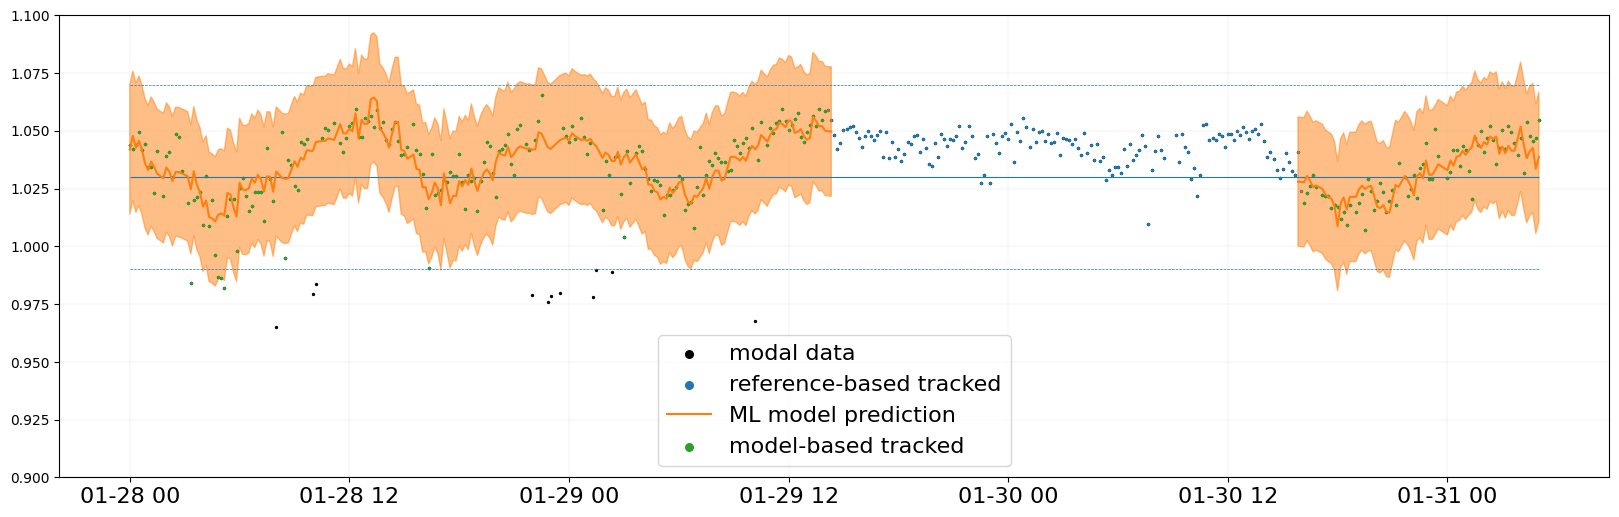

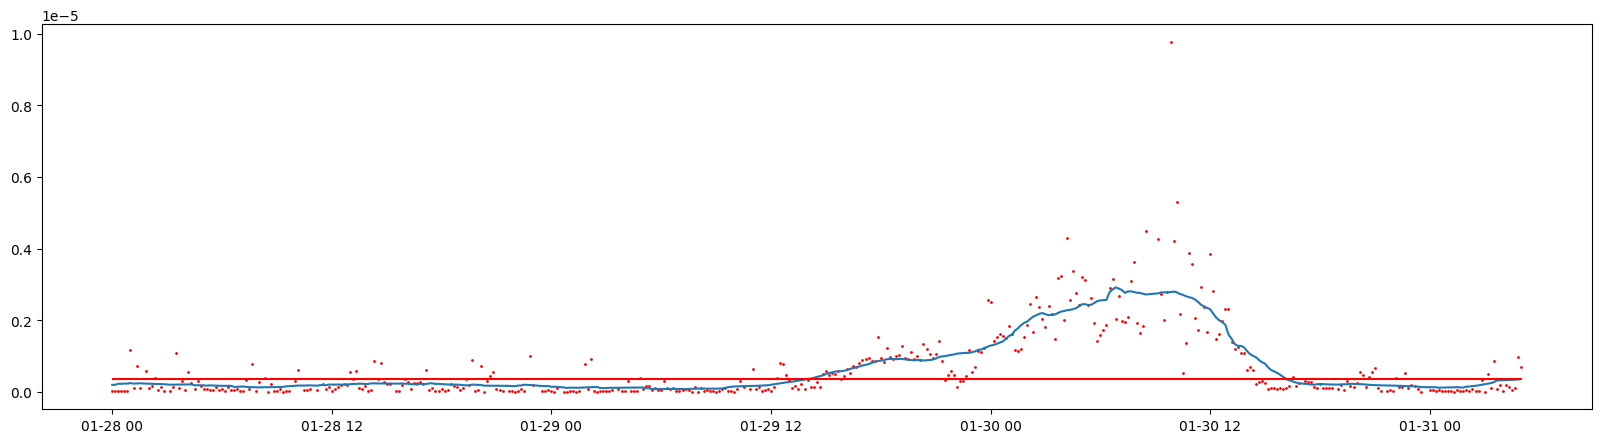

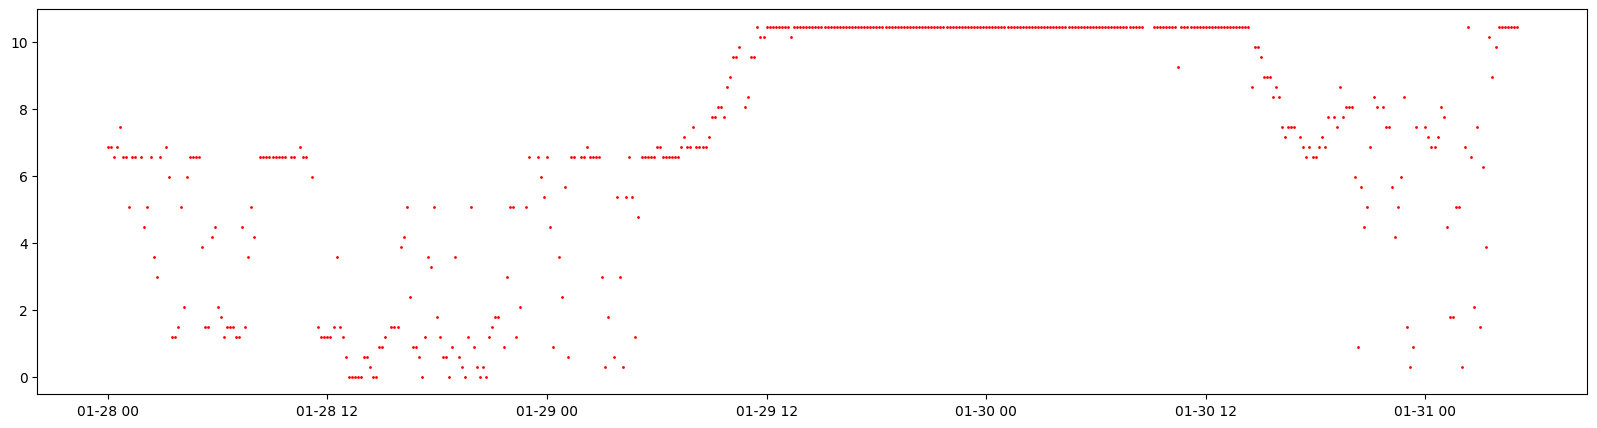

In [10]:
analyzed_timeframe = (
    datetime.datetime(2023, 1, 28, tzinfo=datetime.timezone.utc),
    datetime.datetime(2023, 1, 31,5, tzinfo=datetime.timezone.utc)
)
#prediction_lim = np.abs((y - predictions_df['prediction']).loc[X_train.index]).quantile(0.99)
prediction_lim = (y - predictions_df['prediction']).loc[X_train.index].std()*2

plt_selected_input_data = X.loc[analyzed_timeframe[0]:analyzed_timeframe[1]]
plt_modal_data = y.loc[analyzed_timeframe[0]:analyzed_timeframe[1]]
plt_predictions = predictions_df.loc[analyzed_timeframe[0]:analyzed_timeframe[1]]
low_uncertainty = uncertainty_[uncertainty_moving_avg < uncertainty_lim].index
common_indices = plt_predictions.index.intersection(low_uncertainty)
plt_predictions_low_uncertainty = plt_predictions.loc[common_indices]
resampled_plt_predictions = plt_predictions_low_uncertainty.resample('10T').asfreq()['prediction']
resampled_plt_predictions.interpolate(method='linear', inplace=True, limit_direction='both', limit=2)
plt_smart_tracked = smart_tracked_modes.loc[analyzed_timeframe[0]:analyzed_timeframe[1]]

upper_ref = 1.07
lower_ref = 0.99
reference_tracked = plt_modal_data[(plt_modal_data > lower_ref) & (plt_modal_data < upper_ref)]

plt.figure(figsize=(20, 6))
plt.scatter(plt_modal_data.index, plt_modal_data, color='k', s=2, label='modal data')
plt.hlines(upper_ref, analyzed_timeframe[0], analyzed_timeframe[1], color='tab:blue', linewidth=0.5, linestyle='--')
plt.hlines(lower_ref, analyzed_timeframe[0], analyzed_timeframe[1], color='tab:blue', linewidth=0.5, linestyle='--')
plt.hlines((lower_ref+upper_ref)/2 , analyzed_timeframe[0], analyzed_timeframe[1], color='tab:blue', linewidth=0.8)
plt.scatter(reference_tracked.index, reference_tracked, color='tab:blue', s=2, label='reference-based tracked')
#plt.plot(plt_predictions['prediction'])
#plt.scatter(plt_predictions.index, plt_predictions['prediction'], color='tab:orange', s=1)
#plt.scatter(plt_predictions_low_uncertainty.index, plt_predictions_low_uncertainty['prediction'], color='tab:blue', s=10)
plt.plot(resampled_plt_predictions, color='tab:orange', label='ML model prediction')
plt.fill_between(resampled_plt_predictions.index, resampled_plt_predictions-prediction_lim, resampled_plt_predictions+prediction_lim, alpha=0.5, color='tab:orange')

plt.scatter(plt_smart_tracked.index, plt_smart_tracked['frequency'], color='tab:green', s=2, label='model-based tracked')

legend = plt.legend(loc='lower center', fontsize=16)
for handles in legend.legendHandles:
    try:
        handles.set_sizes([30.0])
    except:
        pass
plt.xticks(fontsize=16)
plt.grid(linewidth=0.1)
plt.ylim(0.9, 1.1)
plt.show()
plt.close()

plt.figure(figsize=(20,5))
plt.plot(uncertainty_moving_avg.loc[analyzed_timeframe[0]:analyzed_timeframe[1]])
plt.hlines(uncertainty_lim, analyzed_timeframe[0], analyzed_timeframe[1], color='r')
plt.scatter(virtual_ensemble_preds_df.loc[analyzed_timeframe[0]:analyzed_timeframe[1]].index, virtual_ensemble_preds_df.loc[analyzed_timeframe[0]:analyzed_timeframe[1]]['knowledge uncertainty'], s=1, c='r')
plt.show()
plt.close()
plt.figure(figsize=(20,5))
plt.scatter(plt_selected_input_data.index, plt_selected_input_data['mean_NW2_C02_rpm'], s=1, c='r')
plt.show()
plt.close()

# Sparcity plots

In [11]:
import pandas as pd
from sklearn.metrics import mean_squared_error

def optimized_sparcity_plot_values(prediction_df_, target_):
    prediction_df = prediction_df_.copy()
    target = target_.copy()
    # Pre-compute the order of dropping based on 'knowledge_uncertainty'
    drop_order = prediction_df['knowledge_uncertainty'].argsort()

    # Pre-calculate the MSE for the entire dataset
    initial_mse = mean_squared_error(prediction_df['prediction'], target)

    # Pre-allocate memory for sparcity_values
    sparcity_values = [initial_mse] * len(prediction_df)
    prediction_df.reset_index(inplace=True, drop=True)
    target.reset_index(inplace=True, drop=True)
    for i in range(len(prediction_df) - 1):
        # Drop the next row in the pre-calculated order
        prediction_df.drop(drop_order.iloc[-(i+1)], inplace=True)
        target.drop(drop_order.iloc[-(i+1)], inplace=True)

        # Update the MSE in sparcity_values
        mse_i = mean_squared_error(prediction_df['prediction'], target)
        sparcity_values[i + 1] = mse_i

    return sparcity_values


In [12]:
sparcity_values = optimized_sparcity_plot_values(predictions_df, y)

In [13]:
import pandas as pd
from sklearn.metrics import mean_squared_error

def corr_sparcity_plot_values(prediction_df_, target_, corr_:pd.Series):
    prediction_df = prediction_df_.copy()
    target = target_.copy()
    corr = corr_.copy()
    corr_df = pd.DataFrame({'frequency':target, 'Corr': corr})

    # Pre-compute the order of dropping based on 'knowledge_uncertainty'
    drop_order = prediction_df['knowledge_uncertainty'].argsort()

    # Pre-calculate the corr for the entire dataset
    initial_corr = corr_df.corr().iloc[0,1]

    # Pre-allocate memory for sparcity_values
    sparcity_values = [initial_corr] * len(prediction_df)
    prediction_df.reset_index(inplace=True, drop=True)
    target.reset_index(inplace=True, drop=True)
    corr.reset_index(inplace=True, drop=True)
    for i in range(len(prediction_df) - 1):
        # Drop the next row in the pre-calculated order
        prediction_df.drop(drop_order.iloc[-(i+1)], inplace=True)
        target.drop(drop_order.iloc[-(i+1)], inplace=True)
        corr.drop(drop_order.iloc[-(i+1)], inplace=True)


        # Update the MSE in sparcity_values
        corr_df = pd.DataFrame({'frequency':target, 'Corr': corr})
        corr_i = corr_df.corr().iloc[0,1]
        sparcity_values[i + 1] = corr_i
    return sparcity_values

In [14]:
correlation_param = pd.Series(X.filter(regex='Tide').values[:,0], index=X.index)
corr_sparcity_values = corr_sparcity_plot_values(predictions_df, y, correlation_param)

In [15]:
smart_tracked_modes_all = smart_tracking(y, predictions_df['prediction'], uncertainty_moving_avg, uncertainty_moving_avg.max(), prediction_lim)

In [16]:
smart_tracked_modes_all['knowledge_uncertainty'] = predictions_df['knowledge_uncertainty']

In [17]:
smart_tracked_modes_all['frequency']

timestamp
2023-01-01 03:00:00+00:00    1.035454
2023-01-01 03:10:00+00:00    1.030419
2023-01-01 03:20:00+00:00    1.042198
2023-01-01 03:30:00+00:00    1.019736
2023-01-01 03:40:00+00:00    1.030911
                               ...   
2023-05-31 19:50:00+00:00    1.045638
2023-05-31 20:00:00+00:00    1.042135
2023-05-31 20:50:00+00:00    1.020880
2023-05-31 21:00:00+00:00    1.038271
2023-05-31 21:10:00+00:00    1.012375
Name: frequency, Length: 18334, dtype: float64

In [18]:
import pandas as pd
from sklearn.metrics import mean_squared_error

def corr_sparcity_plot_values_smart_tracked(prediction_df_, target_, corr_:pd.Series, smart_tracked_modes_full):
    prediction_df = prediction_df_.copy()
    target = target_.copy()
    smart_tracked_modes_ = smart_tracked_modes_full.copy()
    corr = corr_.copy().loc[smart_tracked_modes_.index]

    corr_df = pd.DataFrame({'frequency':smart_tracked_modes_['frequency'], 'Corr': corr})

    # Pre-compute the order of dropping based on 'knowledge_uncertainty'
    drop_order = smart_tracked_modes_['knowledge_uncertainty'].argsort()

    # Pre-calculate the corr for the entire dataset
    initial_corr = corr_df.corr().iloc[0,1]
    initial_mse = mean_squared_error(prediction_df['prediction'].loc[smart_tracked_modes_.index], smart_tracked_modes_['frequency'], squared=False)
    # Pre-allocate memory for sparcity_values
    corr_sparcity_values = [initial_corr] * len(prediction_df)
    mse_sparcity_values = [initial_mse] * len(prediction_df)
    prediction_df.reset_index(inplace=True, drop=True)
    target.reset_index(inplace=True, drop=True)
    corr.reset_index(inplace=True, drop=True)
    smart_tracked_modes_.reset_index(inplace=True, drop=True)
    for i in range(len(smart_tracked_modes_) - 1):
        # Drop the next row in the pre-calculated order
        print(mean_squared_error(prediction_df['prediction'].loc[smart_tracked_modes_.index], smart_tracked_modes_['frequency'], squared=False))
        corr.drop(drop_order.iloc[-(i+1)], inplace=True)
        smart_tracked_modes_.drop(drop_order.iloc[-(i+1)], inplace=True)
        prediction_df.drop(drop_order.iloc[-(i+1)], inplace=True)
        target.drop(drop_order.iloc[-(i+1)], inplace=True)

        # Update the MSE in sparcity_values
        mse_i = mean_squared_error(prediction_df['prediction'].loc[smart_tracked_modes_.index], smart_tracked_modes_['frequency'], squared=False)
        mse_sparcity_values[i+1] = mse_i

        corr_df = pd.DataFrame({'frequency':smart_tracked_modes_['frequency'], 'Corr': corr})
        corr_i = corr_df.corr().iloc[0,1]
        corr_sparcity_values[i + 1] = corr_i
    return corr_sparcity_values, mse_sparcity_values

In [19]:
smart_tracked_modes_spacity, mse_sparcity_values = corr_sparcity_plot_values_smart_tracked(predictions_df, y, correlation_param, smart_tracked_modes_all)

0.01814295178988591
0.018143445491566632
0.01814392855583415
0.018142719512841663
0.018143199842953924
0.01814340208477944
0.018143896253393767
0.018144389615401525
0.01814431529348423
0.01814480938566181
0.018145304487134747
0.01814579906287374
0.01814594023138648
0.018146122449064103
0.01814653498762131
0.018146930534080133
0.018146665305684834
0.01814566004583599
0.01814613791569451
0.01814659846967758
0.01814702397556377
0.018147500150834436
0.018147987537173612
0.018148419637465454
0.01814884621321846
0.01814901963584003
0.018149506169778756
0.018149892843172016
0.018150386597583227
0.01815001877341021
0.01814976399764081
0.018148775489356585
0.018148903345866055
0.018148889050406566
0.0181493739137799
0.018149664897239223
0.018150148963543934
0.018150358905992675
0.018150497726480204
0.01814921854872228
0.018149673085259194
0.018150162898054517
0.018150555324961418
0.01815104312112445
0.018151479028480744
0.018151881453646615
0.018152377427625977
0.01815282805688989
0.01815329995

In [20]:
mean_squared_error(predictions_df['prediction'].loc[smart_tracked_modes_all.index], smart_tracked_modes_all['frequency'], squared=False)

0.010658523446849297

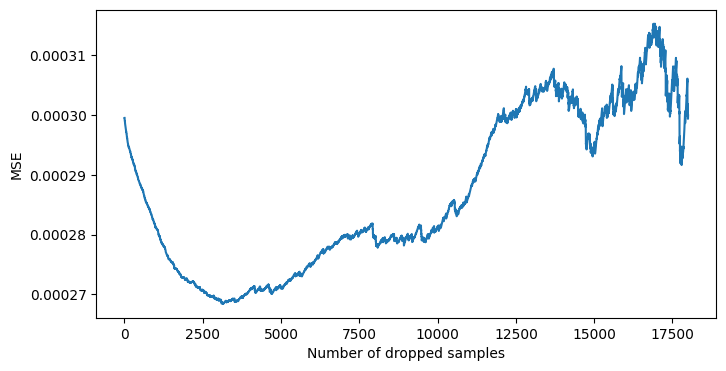

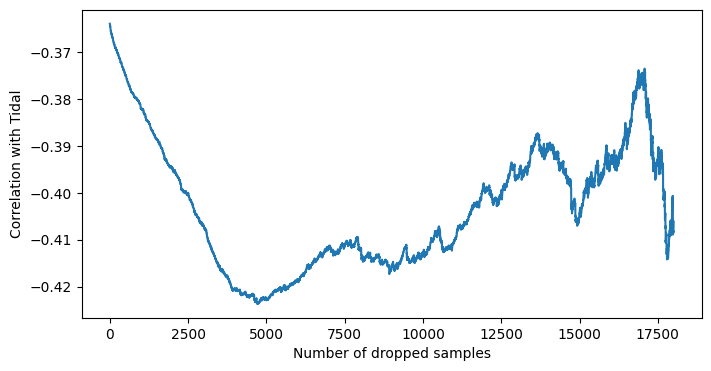

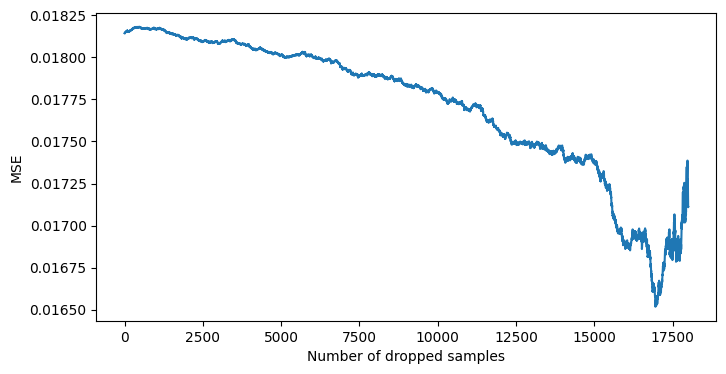

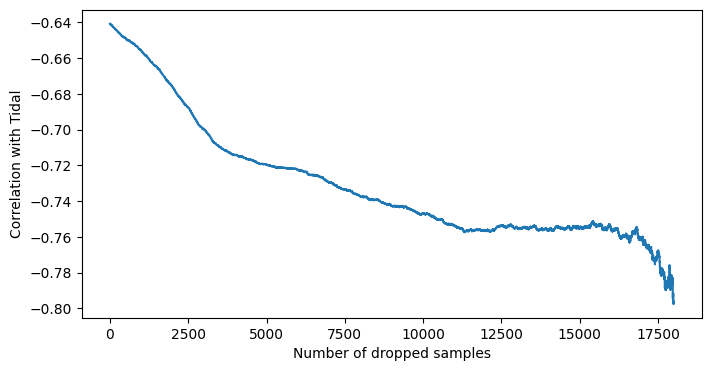

In [21]:
limit = 18000

plt.figure(figsize=(8,4))
plt.plot(sparcity_values[:limit])
plt.xlabel('Number of dropped samples')
plt.ylabel('MSE')
plt.show()
plt.close()

plt.figure(figsize=(8,4))
plt.plot(corr_sparcity_values[:limit])
plt.xlabel('Number of dropped samples')
plt.ylabel('Correlation with Tidal')
plt.show()
plt.close()

plt.figure(figsize=(8,4))
plt.plot(mse_sparcity_values[1:limit])
plt.xlabel('Number of dropped samples')
plt.ylabel('MSE')
plt.show()
plt.close()

plt.figure(figsize=(8,4))
plt.plot(smart_tracked_modes_spacity[:limit])
plt.xlabel('Number of dropped samples')
plt.ylabel('Correlation with Tidal')
plt.show()
plt.close()

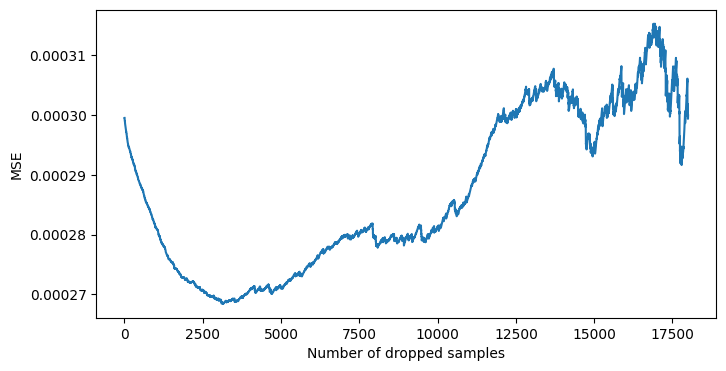

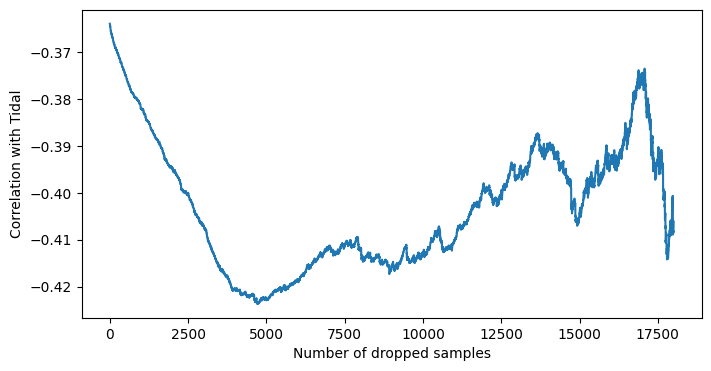

In [22]:
limit = 18000

plt.figure(figsize=(8,4))
plt.plot(sparcity_values[:limit])
plt.xlabel('Number of dropped samples')
plt.ylabel('MSE')
plt.show()
plt.close()

plt.figure(figsize=(8,4))
plt.plot(corr_sparcity_values[:limit])
plt.xlabel('Number of dropped samples')
plt.ylabel('Correlation with Tidal')
plt.show()
plt.close()

In [23]:
print(predictions_df['knowledge_uncertainty'].iloc[predictions_df['knowledge_uncertainty'].argsort().iloc[-np.array(corr_sparcity_values[:limit]).argmin()]])
print(predictions_df['knowledge_uncertainty'].iloc[predictions_df['knowledge_uncertainty'].argsort().iloc[-np.array(sparcity_values[:limit]).argmin()]])

6.420805000224831e-07
9.35571088829122e-07


In [24]:
uncertainty_moving_avg.loc[X_train.index].max()


5.057766033004461e-07